In [30]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import gc
import psutil
import warnings
warnings.filterwarnings('ignore')


pd.set_option('mode.copy_on_write', True)  # Reduce memory usage
CHUNK_SIZE = 50000  # Process in chunks
MAX_MEMORY_PCT = 0.7  # Use max 70% of available RAM

def get_memory_usage():
    """Get current memory usage"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # MB

def optimize_dtypes(df):
    """Optimize data types to reduce memory usage"""
    print("Optimizing data types...")
    original_memory = df.memory_usage(deep=True).sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object' and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    # Convert categorical string columns
    for col in df.select_dtypes(include=['object']):
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    
    new_memory = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Memory usage reduced from {original_memory:.1f}MB to {new_memory:.1f}MB ({100*(original_memory-new_memory)/original_memory:.1f}% reduction)")
    
    return df

def smart_sample(df, target_size=500000, event_col='survival_event', duration_col='survival_time'):
    """
    Intelligent sampling that preserves statistical properties
    """
    print(f"Original data size: {len(df):,} rows")
    
    if len(df) <= target_size:
        print("Data size is acceptable, no sampling needed")
        return df.copy()
    
    # Stratified sampling to maintain event ratio and duration distribution
    print("Performing stratified sampling...")
    
    # Create strata based on events and duration quartiles
    df_sample = df.copy()
    
    # Add quartile bins for stratification
    df_sample['duration_quartile'] = pd.qcut(df_sample[duration_col], 
                                           q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], 
                                           duplicates='drop')
    
    # Create combined strata
    df_sample['strata'] = df_sample[event_col].astype(str) + '_' + df_sample['duration_quartile'].astype(str)
    
    # Stratified sampling
    sss = StratifiedShuffleSplit(n_splits=1, 
                                train_size=target_size/len(df), 
                                random_state=42)
    
    train_idx, _ = next(sss.split(df_sample, df_sample['strata']))
    sampled_df = df_sample.iloc[train_idx].drop(['duration_quartile', 'strata'], axis=1)
    
    # Verify sampling quality
    orig_event_rate = df[event_col].mean()
    sample_event_rate = sampled_df[event_col].mean()
    
    print(f"Sampled data size: {len(sampled_df):,} rows")
    print(f"Original event rate: {orig_event_rate:.3f}")
    print(f"Sample event rate: {sample_event_rate:.3f}")
    print(f"Event rate preservation: {abs(orig_event_rate - sample_event_rate):.4f} difference")
    
    return sampled_df

def load_and_prepare_data_efficiently(filepath):
    """
    Efficiently load and prepare large parquet file
    """
    print(f"Loading data from {filepath}")
    print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.1f} GB")
    
    try:
        # Load with optimized settings
        df = pd.read_parquet(filepath, 
                           engine='pyarrow',
                           use_nullable_dtypes=True)
        
        print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")
        
        # Immediate memory optimization
        df = optimize_dtypes(df)
        
        # Handle datetime columns efficiently
        datetime_cols = ['ORIG_DATE', 'FORECLOSURE_DATE', 'MATR_DT', 'quarter']
        for col in datetime_cols:
            if col in df.columns:
                try:
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                except:
                    continue
        
        # Smart sampling for Mac Air constraints
        df = smart_sample(df)
        
        # Final cleanup
        gc.collect()
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def identify_macro_features_fast(df):
    """Fast macro feature identification"""
    macro_keywords = [
        'rates_PC', 'employment_PC', 'inflation_PC', 'activity_PC', 
        'housing_PC', 'sentiment_PC', 'UNRATE', 'FEDFUNDS', 'GS10', 
        'CFNAI', 'yield_spread', 'unemployment_regime', 'interest_rate_regime',
        'yield_curve_regime', 'economic_stress', 'yield_curve_inversion',
        'macro_quarter'
    ]
    
    macro_features = [col for col in df.columns 
                     if any(keyword in col for keyword in macro_keywords)]
    
    print(f"Identified {len(macro_features)} macro features")
    return macro_features

def prepare_cox_data_efficient(df, duration_col='survival_time', event_col='survival_event'):
    """
    Efficient Cox data preparation with enhanced data cleaning
    """
    print("Preparing Cox regression data...")
    
    # Check if required columns exist
    if duration_col not in df.columns or event_col not in df.columns:
        print(f"Required columns missing: {duration_col}, {event_col}")
        return None, None
    
    # Essential columns to keep
    essential_cols = [duration_col, event_col]
    
    # Columns to exclude (reduce dimensionality)
    exclude_patterns = [
        'LOAN_ID', 'Zero_Bal_Code', 'quarter', 'orig_year',
        'default_events', 'stage2_event', 'time_to_default_raw',
        'stage2_survival_time', 'stage2_survival_event',
        'ifrs9_stage', 'default_12m', 'stage2_12m', 'ORIG_DATE',
        'FORECLOSURE_DATE', 'MATR_DT','default_event', 'ever_default_dlq', 'first_default_age_dlq',
    'ever_stage2', 'first_stage2_age', 'ever_default_zb',
    'last_observed_age'
    ]
    
    # Select numeric feature columns only
    feature_cols = []
    for col in df.columns:
        if (col not in essential_cols and 
            not any(pattern in col for pattern in exclude_patterns) and
            pd.api.types.is_numeric_dtype(df[col]) and
            df[col].var() > 0):  # Remove zero-variance columns
            feature_cols.append(col)
    
    print(f"Selected {len(feature_cols)} numeric features for modeling")
    
    # Create final dataset with only necessary columns
    final_cols = essential_cols + feature_cols
    cox_data = df[final_cols].copy()
    
    # Enhanced data cleaning
    print("Cleaning data...")
    original_rows = len(cox_data)
    
    # Remove invalid durations and events
    cox_data = cox_data.dropna(subset=essential_cols)
    cox_data = cox_data[cox_data[duration_col] > 0]
    cox_data = cox_data[cox_data[event_col].isin([0, 1])]
    
    print(f"Removed {original_rows - len(cox_data):,} rows with invalid duration/event data")
    
    # Handle remaining NaNs in features
    for col in feature_cols:
        if cox_data[col].isna().any():
            # Use median for numeric columns
            median_val = cox_data[col].median()
            cox_data[col] = cox_data[col].fillna(median_val)
    
    # Remove features with infinite values
    for col in feature_cols:
        if np.isinf(cox_data[col]).any():
            print(f"Removing feature {col} due to infinite values")
            cox_data = cox_data.drop(columns=[col])
            feature_cols.remove(col)
    
    # Final validation
    print(f"Final Cox data: {len(cox_data):,} rows, {len(feature_cols)} features")
    print(f"Event rate: {cox_data[event_col].mean():.3f}")
    print(f"Duration range: {cox_data[duration_col].min():.1f} to {cox_data[duration_col].max():.1f}")
    
    # Memory cleanup
    del df
    gc.collect()
    
    return cox_data, feature_cols

def fit_cox_model_optimized(data, features, duration_col='survival_time', 
                           event_col='survival_event', model_name="Model",
                           max_features=50):
    """
    Optimized Cox model fitting with feature selection
    """
    print(f"\nFitting {model_name}")
    print(f"Memory usage: {get_memory_usage():.1f} MB")
    
    # Feature selection if too many features
    if len(features) > max_features:
        print(f"Reducing {len(features)} features to {max_features} via correlation analysis...")
        
        # Calculate correlation with target (for feature selection)
        feature_data = data[features + [event_col]]
        correlations = feature_data.corr()[event_col].abs().sort_values(ascending=False)
        selected_features = correlations.head(max_features).index.tolist()
        selected_features.remove(event_col)
        features = selected_features
        print(f"Selected {len(features)} most predictive features")
    
    # Prepare model data
    model_cols = [duration_col, event_col] + features
    model_data = data[model_cols].copy()
    
    # Standardize features in chunks to save memory
    print("Standardizing features...")
    scaler = StandardScaler()
    
    # Fit scaler on sample, transform in chunks
    sample_size = min(10000, len(model_data))
    sample_idx = np.random.choice(len(model_data), sample_size, replace=False)
    scaler.fit(model_data.iloc[sample_idx][features])
    
    # Transform in chunks
    chunk_size = 10000
    for i in range(0, len(model_data), chunk_size):
        end_idx = min(i + chunk_size, len(model_data))
        model_data.loc[model_data.index[i:end_idx], features] = scaler.transform(
            model_data.iloc[i:end_idx][features]
        )
    
    # Fit Cox model with optimized settings
    print("Fitting Cox proportional hazards model...")
    cph = CoxPHFitter(penalizer=0.1)  # Light regularization for stability
    
    try:
        # Fit model with compatible parameters
        cph.fit(model_data, duration_col=duration_col, event_col=event_col, 
               show_progress=False)
        
        print(f"✓ Model fitted successfully!")
        print(f"  Features: {len(features)}")
        print(f"  Observations: {len(model_data):,}")
        print(f"  Events: {int(model_data[event_col].sum()):,}")
        print(f"  Concordance Index: {cph.concordance_index_:.4f}")
        print(f"  Partial AIC: {cph.AIC_partial_:.2f}")

        
        # Force garbage collection
        gc.collect()
        
        
        # Add predictions and diagnostics
        model_data['predicted_partial_hazard'] = cph.predict_partial_hazard(model_data).values

        # Estimate baseline cumulative hazard at the final observed duration
        baseline_hazard = cph.baseline_cumulative_hazard_
        model_data['baseline_cumulative_hazard'] = baseline_hazard.iloc[-1, 0]

        # Expected cumulative hazard is: baseline_hazard * partial hazard
        model_data['expected_cumulative_hazard'] = (
        model_data['predicted_partial_hazard'] * model_data['baseline_cumulative_hazard']
        )

        # Residual: actual time - expected hazard
        model_data['residual'] = model_data[duration_col] - model_data['expected_cumulative_hazard']

        # Final return structure
        return {
            'model': cph,
            'scaler': scaler,
            'data': model_data,
            'features': features,
        }

        
    except Exception as e:
        print(f"✗ Error fitting {model_name}: {str(e)}")
        
        # Additional debugging
        print(f"  Model data shape: {model_data.shape}")
        print(f"  Features with NaN: {model_data[features].isna().sum().sum()}")
        print(f"  Duration range: {model_data[duration_col].min():.2f} to {model_data[duration_col].max():.2f}")
        print(f"  Event rate: {model_data[event_col].mean():.3f}")
        
        # Try with even more regularization
        if 'penalizer' not in str(e).lower():
            print("Trying with stronger regularization...")
            try:
                cph_robust = CoxPHFitter(penalizer=0.1)
                cph_robust.fit(model_data, duration_col=duration_col, event_col=event_col, 
                             show_progress=False)
                
                print(f"Robust model fitted!")
                print(f"Concordance Index: {cph_robust.concordance_index_:.4f}")
                gc.collect()
                return cph_robust, scaler, model_data, features
                
            except Exception as e2:
                print(f"Robust fitting also failed: {str(e2)}")
        
        # Final fallback: reduce features more aggressively
        if len(features) > 15:
            print(f"Final attempt with top 15 features...")
            features_minimal = features[:15]
            return fit_cox_model_optimized(data, features_minimal, duration_col, 
                                         event_col, f"{model_name} (Minimal)", 15)
        
        return None, None, None, None

def compare_models_efficient(model1, model2, data1, data2, features1, features2,
                           model1_name="Non-Macro", model2_name="Full"):
    """
    Efficient model comparison - FIXED to use AIC_partial_
    """
    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON: {model1_name} vs {model2_name}")
    print(f"{'='*60}")
    
    if model1 is None or model2 is None:
        print("Cannot compare - one or both models failed to fit")
        return
    
    # Comparison metrics
    metrics = {
        'Model': [model1_name, model2_name],
        'Features': [len(features1), len(features2)],
        'Observations': [f"{len(data1):,}", f"{len(data2):,}"],
        'Events': [f"{int(data1[model1.event_col].sum()):,}", 
                   f"{int(data2[model2.event_col].sum()):,}"],
        'C-Index': [f"{model1.concordance_index_:.4f}", 
                    f"{model2.concordance_index_:.4f}"],
        'Partial AIC': [f"{model1.AIC_partial_:.1f}", f"{model2.AIC_partial_:.1f}"],
        'Log-Likelihood': [f"{model1.log_likelihood_:.1f}", 
                          f"{model2.log_likelihood_:.1f}"]
    }
    
    comparison_df = pd.DataFrame(metrics)
    print(comparison_df.to_string(index=False))
    
    # Key metrics comparison
    c_improvement = model2.concordance_index_ - model1.concordance_index_
    aic_improvement = model1.AIC_partial_ - model2.AIC_partial_  # Lower AIC is better
    
    print(f"\n{'='*40}")
    print("KEY RESULTS")
    print(f"{'='*40}")
    print(f"C-Index Improvement: {c_improvement:+.4f} ({c_improvement*100:+.2f}%)")
    print(f"Partial AIC Improvement: {aic_improvement:+.1f}")
    
    if c_improvement > 0.01:
        print("✓ MEANINGFUL predictive improvement with macro features")
    elif c_improvement > 0.005:
        print("MODEST predictive improvement with macro features")
    else:
        print(" MINIMAL predictive improvement with macro features")
    
    if aic_improvement > 2:
        print(" SUBSTANTIAL model improvement (Partial AIC)")
    elif aic_improvement > 0:
        print(" MINOR model improvement (Partial AIC)")
    else:
        print(" MODEL COMPLEXITY may not be justified (Partial AIC)")
    
    # Statistical test if models are nested
    if len(features2) > len(features1):
        lr_stat = 2 * (model2.log_likelihood_ - model1.log_likelihood_)
        df_diff = len(features2) - len(features1)
        if df_diff > 0:
            p_value = 1 - stats.chi2.cdf(lr_stat, df_diff)
            print(f"\nLikelihood Ratio Test:")
            print(f"  LR statistic: {lr_stat:.2f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} (α=0.05)")
    
def main_analysis_optimized(filepath_or_df):
    """
    Main optimized analysis with macro_quarter-based time split:
    Train on 2016Q4 to 2020Q4, test on 2021Q1 to 2022Q3
    """
    print("="*80)
    print("OPTIMIZED COX MODEL COMPARISON WITH TIME SPLIT")
    print("Train: Pre-COVID + Early COVID | Test: Post-COVID")
    print("="*80)
    
    # Load data efficiently
    if isinstance(filepath_or_df, str):
        df = load_and_prepare_data_efficiently(filepath_or_df)
    else:
        print("Using provided DataFrame...")
        df = optimize_dtypes(filepath_or_df.copy())
        df = smart_sample(df)
    
    if df is None or 'macro_quarter' not in df.columns:
        print("Missing or invalid input data")
        return None
    
    # Ensure macro_quarter is datetime
    df['macro_quarter'] = pd.to_datetime(df['macro_quarter'], errors='coerce')
    
    # Time-based split
    train_df = df[df['macro_quarter'] <= '2020-12-31'].copy()
    test_df  = df[df['macro_quarter'] > '2020-12-31'].copy()
    
    print(f"\nSPLIT OVERVIEW:")
    print(f"Train set: {len(train_df):,} rows (through 2020 Q4)")
    print(f"Test set: {len(test_df):,} rows (2021 Q1 onward)")
    
    # Identify macro features
    macro_features = identify_macro_features_fast(df)
    
    # Prepare training data
    cox_train, all_features = prepare_cox_data_efficient(train_df)
    if cox_train is None:
        print("Failed to prepare training data")
        return None
    
    non_macro_features = [f for f in all_features if f not in macro_features]
    
    # Fit models on training data
    model1 = fit_cox_model_optimized(
        cox_train, non_macro_features, model_name="Train: Non-Macro Model", max_features=30
    )
    model2 = fit_cox_model_optimized(
        cox_train, all_features, model_name="Train: Full Model", max_features=50
    )
    
    # Prepare test data (apply same cleaning/scaling)
    cox_test, _ = prepare_cox_data_efficient(test_df)
    if cox_test is None:
        print("Failed to prepare test data")
        return None
    
    # Standardize test set with training scaler
    for model_result in [model1, model2]:
        if not model_result:
            continue
        scaler = model_result['scaler']
        features = model_result['features']
        try:
            cox_test.loc[:, features] = scaler.transform(cox_test[features])
        except Exception as e:
            print(f"Scaling failed on test data: {e}")
            continue
    
    # Evaluate trained models on test data
    print(f"\nEVALUATING MODELS ON TEST DATA (2021–2022):")
    for model_result, name in zip([model1, model2], ["Non-Macro", "Full"]):
        if not model_result:
            print(f"{name} model failed.")
            continue
        model = model_result['model']
        features = model_result['features']
        
        try:
            test_cindex = concordance_index(
                cox_test['survival_time'],
                -model.predict_partial_hazard(cox_test[features]),
                cox_test['survival_event']
            )
            print(f"{name} Test Concordance Index: {test_cindex:.4f}")
        except Exception as e:
            print(f"{name} model evaluation failed: {e}")
    
    # Compare models (on training data)
    if model1 and model2:
        compare_models_efficient(
            model1['model'], model2['model'],
            model1['data'], model2['data'],
            model1['features'], model2['features']
        )
        
        print(f"\nFinal memory usage: {get_memory_usage():.1f} MB")
        
        return {
    'non_macro': model1,
    'full': model2,
    'macro_features': [f for f in model2['features'] if f in macro_features],
    'non_macro_features': model1['features'],
    'X_train_full': model2['data'][model2['features']].copy(),
    'y_train_full': Surv.from_dataframe('survival_event', 'survival_time', model2['data']),
    'X_train_non_macro': model1['data'][model1['features']].copy(),
    'y_train_non_macro': Surv.from_dataframe('survival_event', 'survival_time', model1['data']),
    'X_test_full': cox_test[model2['features']].copy(),
    'y_test_full': Surv.from_dataframe('survival_event', 'survival_time', cox_test),
    'X_test_non_macro': cox_test[model1['features']].copy(),
    'y_test_non_macro': Surv.from_dataframe('survival_event', 'survival_time', cox_test),
    'memory_usage': get_memory_usage(),
    }
    else:
        print("One or both models failed to fit.")
        return None
    plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

results = main_analysis_optimized("/Users/sundargodina/Downloads/fred/survival_with_macro_no_nulls.parquet")


OPTIMIZED COX MODEL COMPARISON WITH TIME SPLIT
Train: Pre-COVID + Early COVID | Test: Post-COVID
Loading data from /Users/sundargodina/Downloads/fred/survival_with_macro_no_nulls.parquet
Available RAM: 1.6 GB
Loaded 8,701,018 rows, 75 columns
Optimizing data types...
Memory usage reduced from 5070.0MB to 2398.1MB (52.7% reduction)
Original data size: 8,701,018 rows
Performing stratified sampling...
Sampled data size: 500,000 rows
Original event rate: 0.098
Sample event rate: 0.098
Event rate preservation: 0.0000 difference

📆 SPLIT OVERVIEW:
Train set: 316,068 rows (through 2020 Q4)
Test set: 183,932 rows (2021 Q1 onward)
Identified 29 macro features
Preparing Cox regression data...
Selected 39 numeric features for modeling
Cleaning data...
Removed 0 rows with invalid duration/event data
Final Cox data: 316,068 rows, 39 features
Event rate: 0.145
Duration range: 3.0 to 116.0

Fitting Train: Non-Macro Model
Memory usage: 642.1 MB
Standardizing features...
Fitting Cox proportional hazard

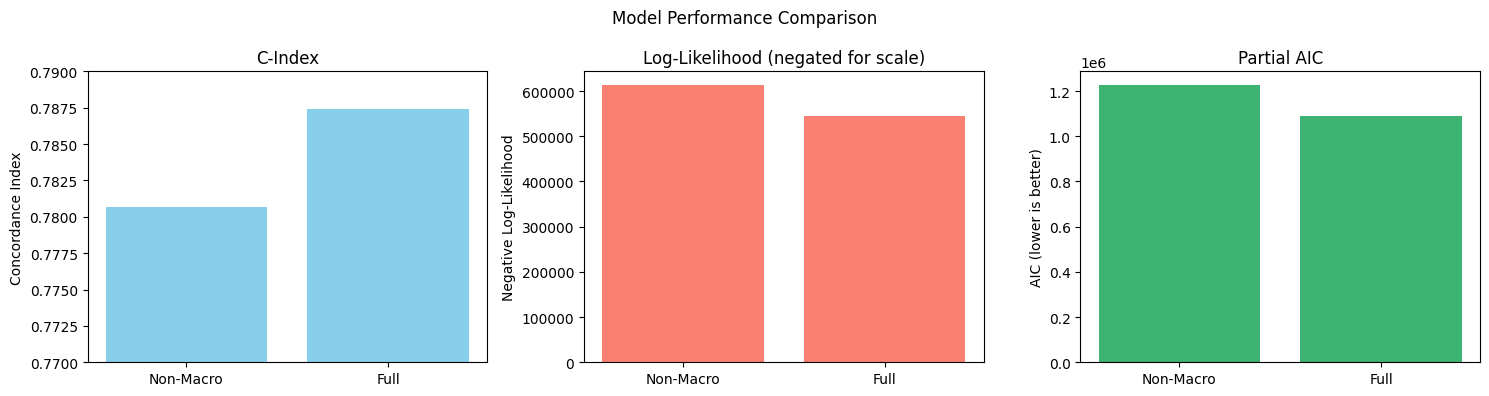

In [22]:
import matplotlib.pyplot as plt

def plot_model_metrics():
    models = ['Non-Macro', 'Full']
    c_index = [0.7807, 0.7874]
    log_likelihood = [-612870.2, -545782.4]
    aic = [1225768.4, 1091642.8]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].bar(models, c_index, color='skyblue')
    axs[0].set_title('C-Index')
    axs[0].set_ylim(0.77, 0.79)
    axs[0].set_ylabel('Concordance Index')

    axs[1].bar(models, [-x for x in log_likelihood], color='salmon')
    axs[1].set_title('Log-Likelihood (negated for scale)')
    axs[1].set_ylabel('Negative Log-Likelihood')

    axs[2].bar(models, aic, color='mediumseagreen')
    axs[2].set_title('Partial AIC')
    axs[2].set_ylabel('AIC (lower is better)')

    plt.suptitle('Model Performance Comparison')
    plt.tight_layout()
    plt.show()

plot_model_metrics()


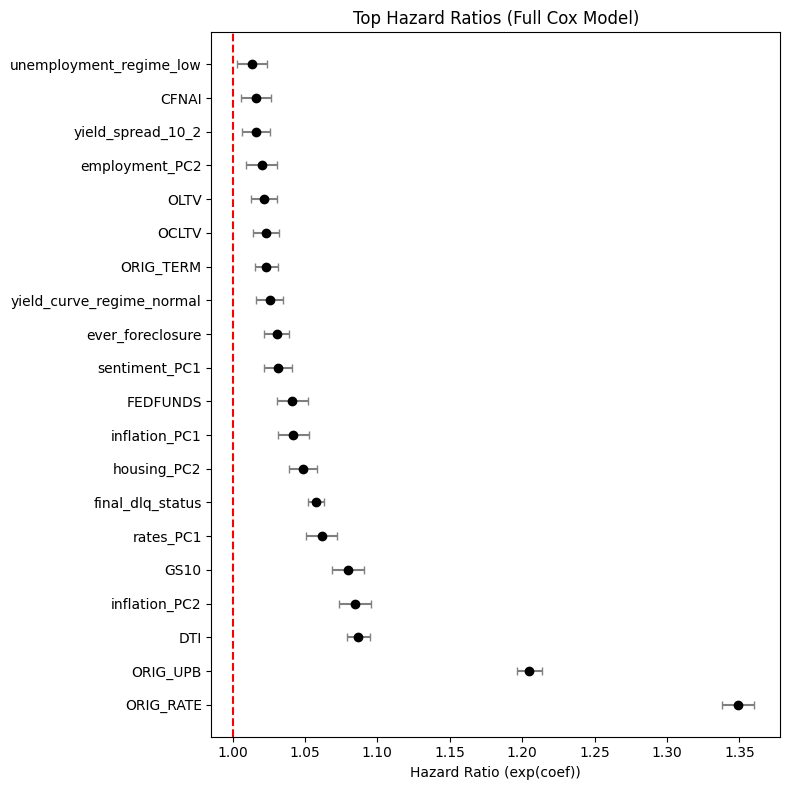

In [21]:
import numpy as np
import pandas as pd

def plot_top_hazard_ratios(model, top_n=20):
    hr = model.params_
    ci = model.confidence_intervals_

    hr_exp = np.exp(hr)
    ci_lower = np.exp(ci.iloc[:, 0])
    ci_upper = np.exp(ci.iloc[:, 1])

    df = pd.DataFrame({
        'HR': hr_exp,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })
    df = df.sort_values(by='HR', ascending=False).head(top_n)

    plt.figure(figsize=(8, top_n * 0.4))
    plt.errorbar(df['HR'], df.index, 
                 xerr=[df['HR'] - df['CI Lower'], df['CI Upper'] - df['HR']],
                 fmt='o', color='black', ecolor='gray', capsize=3)
    plt.axvline(1.0, color='red', linestyle='--')
    plt.xlabel('Hazard Ratio (exp(coef))')
    plt.title('Top Hazard Ratios (Full Cox Model)')
    plt.tight_layout()
    plt.show()

# Call this with:
plot_top_hazard_ratios(results['full']['model'])


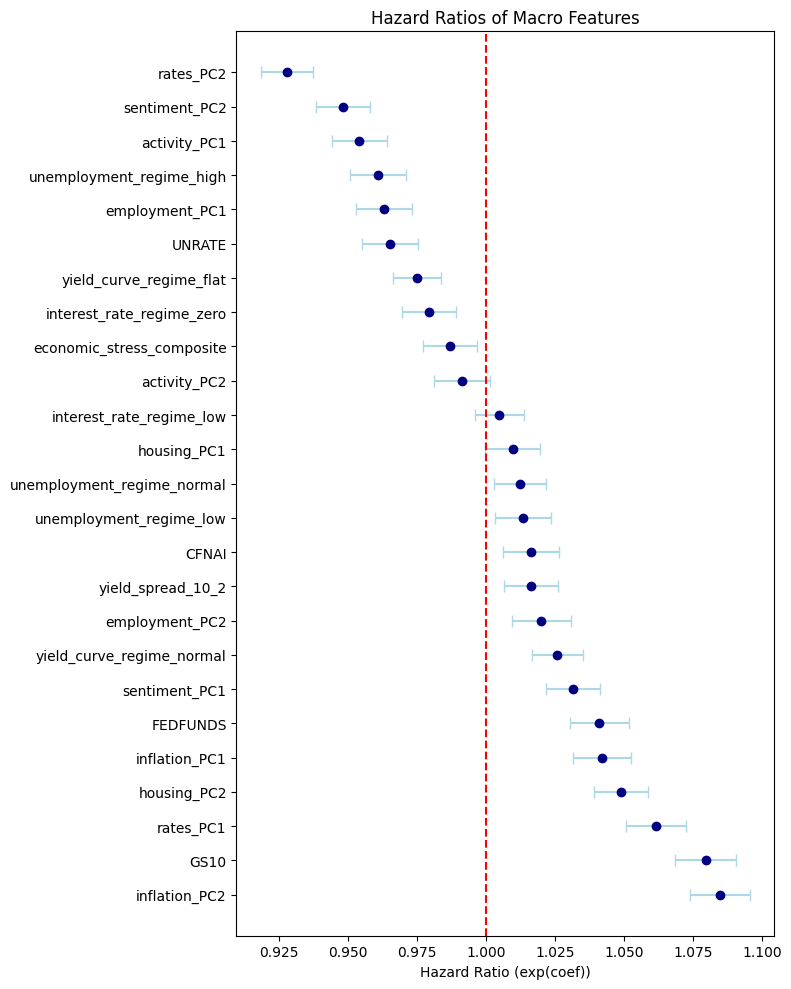

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_macro_feature_importance(results):
    model = results['full']['model']
    macro_feats = results['macro_features']

    # Get hazard ratios and confidence intervals
    hr = model.params_[macro_feats]
    ci = model.confidence_intervals_.loc[macro_feats]

    # Ensure proper column names
    if ci.columns[0] > ci.columns[1]:  # in case they are reversed
        ci = ci[ci.columns[::-1]]

    # Calculate exponentiated values
    hr_exp = np.exp(hr)
    ci_lower = np.exp(ci.iloc[:, 0])
    ci_upper = np.exp(ci.iloc[:, 1])

    df = pd.DataFrame({
        'HR': hr_exp,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })

    # Calculate error bars (ensure they're non-negative)
    df['xerr_low'] = (df['HR'] - df['CI Lower']).clip(lower=0)
    df['xerr_high'] = (df['CI Upper'] - df['HR']).clip(lower=0)

    df = df.sort_values(by='HR', ascending=False)

    # Plotting
    plt.figure(figsize=(8, len(df) * 0.4))
    plt.errorbar(df['HR'], df.index,
                 xerr=[df['xerr_low'], df['xerr_high']],
                 fmt='o', color='navy', ecolor='lightblue', capsize=4)
    plt.axvline(1.0, color='red', linestyle='--')
    plt.title('Hazard Ratios of Macro Features')
    plt.xlabel('Hazard Ratio (exp(coef))')
    plt.tight_layout()
    plt.show()
plot_macro_feature_importance(results)

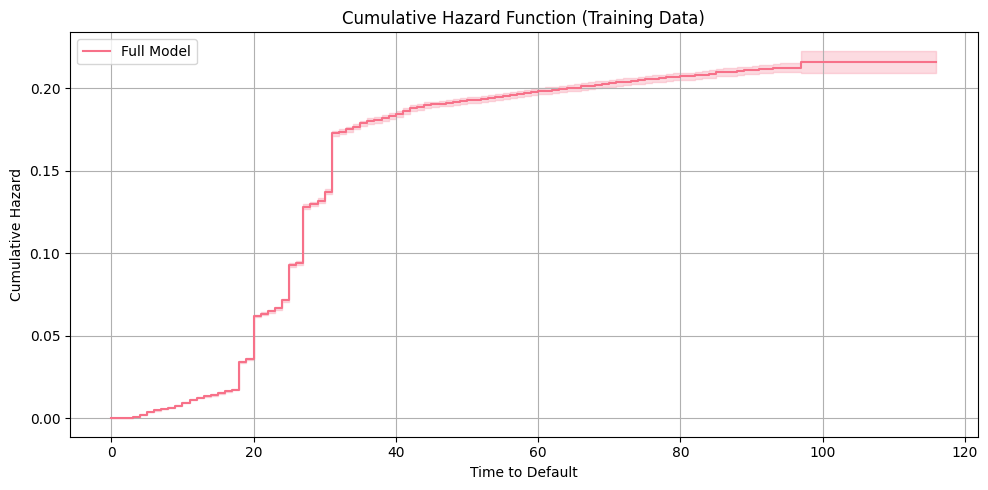

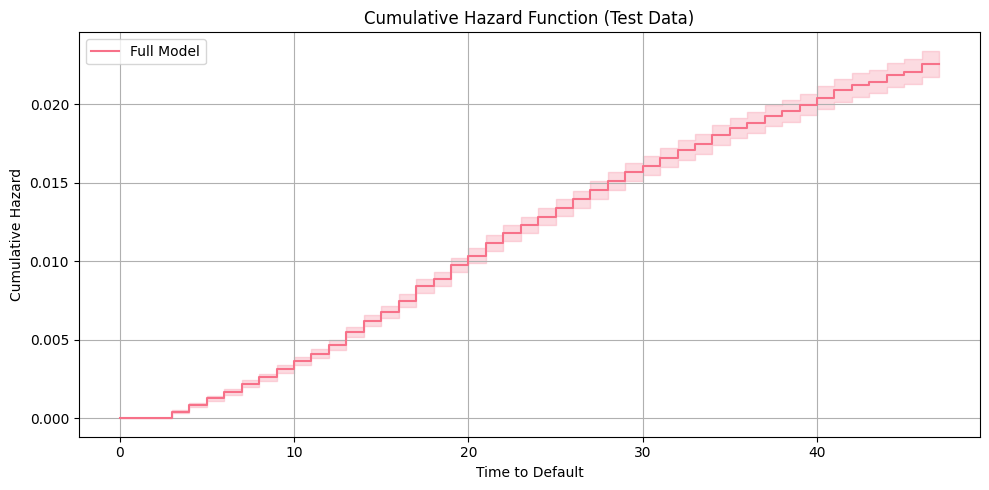

In [29]:
from lifelines import NelsonAalenFitter
import matplotlib.pyplot as plt

def plot_cumulative_hazard(y_surv, label="Model", title_suffix=""):
    """
    Plots the cumulative hazard function from survival data.

    Parameters:
    - y_surv: structured array from Surv.from_dataframe()
    - label: label for legend
    - title_suffix: optional text for plot title
    """
    naf = NelsonAalenFitter()

    T = y_surv["survival_time"]
    E = y_surv["survival_event"]

    naf.fit(T, event_observed=E, label=label)

    plt.figure(figsize=(10, 5))
    naf.plot()
    plt.title(f"Cumulative Hazard Function {title_suffix}")
    plt.xlabel("Time to Default")
    plt.ylabel("Cumulative Hazard")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_cumulative_hazard(results['y_train_full'], label="Full Model", title_suffix="(Training Data)")

plot_cumulative_hazard(results['y_test_full'], label="Full Model", title_suffix="(Test Data)")

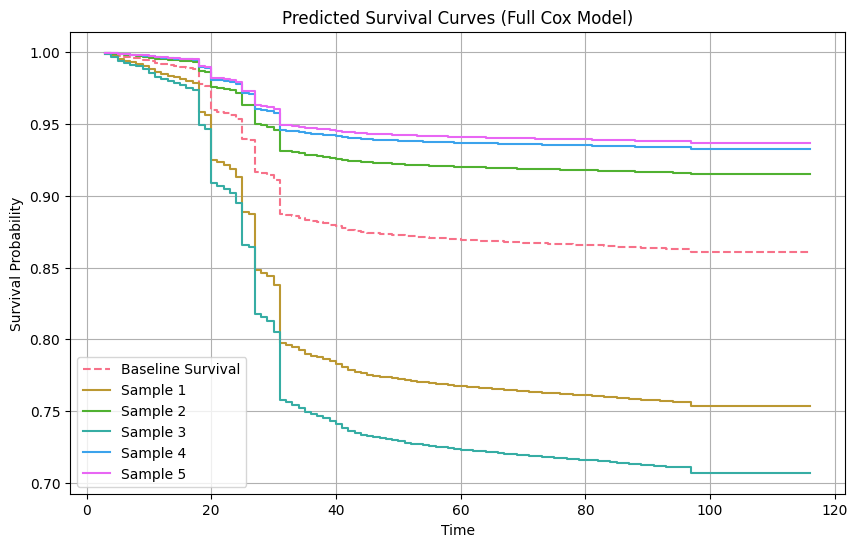

In [52]:
import matplotlib.pyplot as plt

# Extract Cox model and test data from results
cox_model = results['full']['model']
scaler = results['full']['scaler']
features = results['full']['features']
X_test = results['X_test_full']

# Optionally pick a few test samples (e.g., first 5 rows)
sample_X = X_test.iloc[:5]

# Predict survival functions for these samples
surv_funcs = cox_model.predict_survival_function(sample_X)

# Plot baseline survival
plt.figure(figsize=(10, 6))
plt.step(cox_model.baseline_survival_.index, 
         cox_model.baseline_survival_.values.flatten(), 
         where="post", label="Baseline Survival", linestyle='--')

# Plot individual survival curves
for i, col in enumerate(surv_funcs.columns):
    plt.step(surv_funcs.index, surv_funcs[col], where="post", label=f"Sample {i+1}")

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curves (Full Cox Model)")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Extract datasets
X_train_full = results['X_train_full']
y_train_full = results['y_train_full']
X_test_full = results['X_test_full']
y_test_full = results['y_test_full']
X_train_nm = results['X_train_non_macro']
y_train_nm = results['y_train_non_macro']
X_test_nm = results['X_test_non_macro']
y_test_nm = results['y_test_non_macro']

# Train RSF
def train_rsf(X, y):
    model = RandomSurvivalForest(
        n_estimators=50,
        min_samples_split=10,
        min_samples_leaf=15,
        max_features="sqrt",
        n_jobs=-1,
        max_samples=0.1,
        max_depth=10,
        random_state=42
    )
    model.fit(X, y)
    return model

rsf_full = train_rsf(X_train_full, y_train_full)
rsf_nm = train_rsf(X_train_nm, y_train_nm)


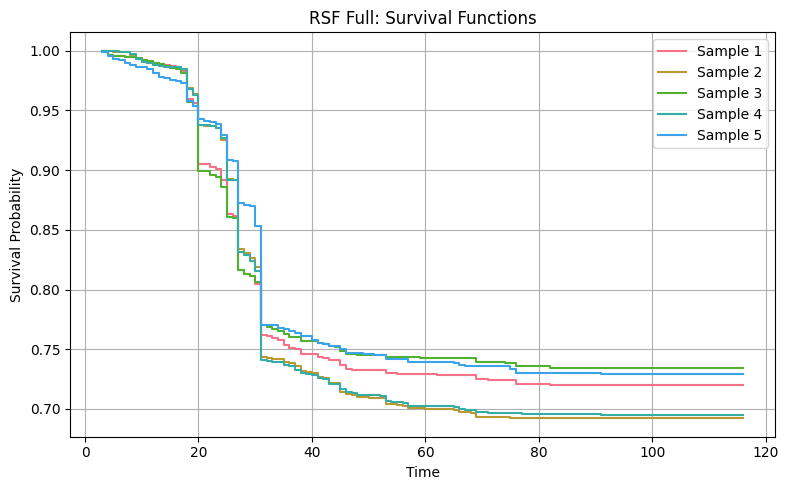

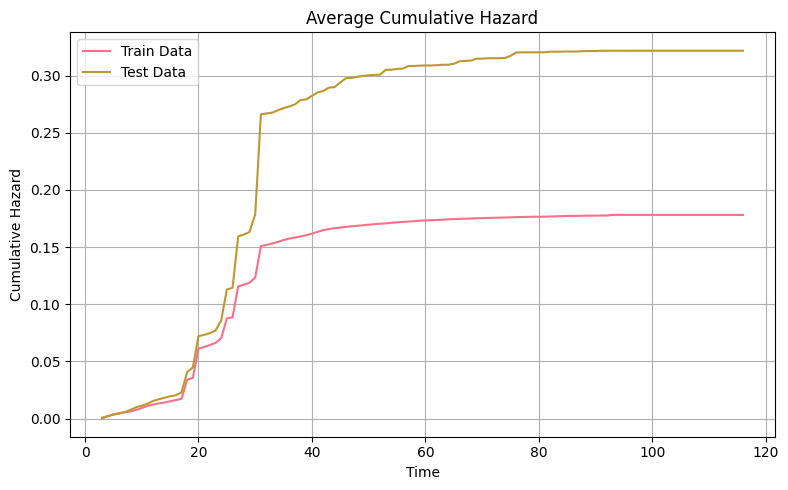

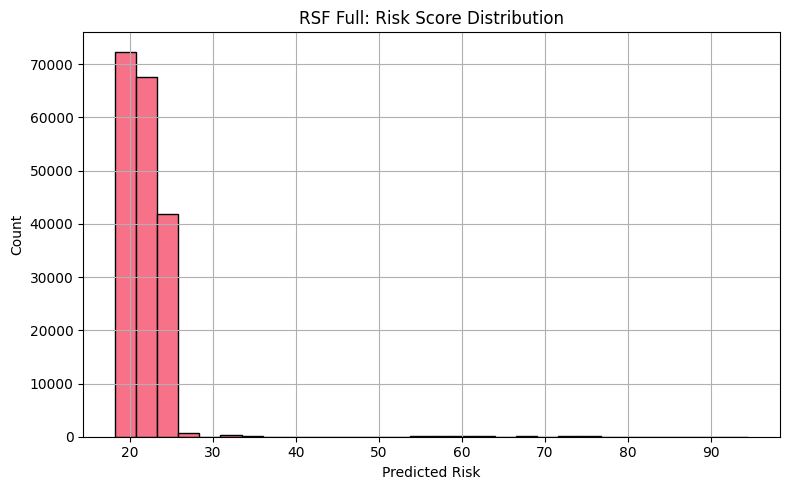

NotImplementedError: 

In [47]:

# C-index calculation
def compute_cindex(model, X_train, y_train, X_test, y_test):
    train_scores = model.predict(X_train)
    test_scores = model.predict(X_test)
    train_c = concordance_index_censored(y_train["survival_event"], y_train["survival_time"], train_scores)[0]
    test_c = concordance_index_censored(y_test["survival_event"], y_test["survival_time"], test_scores)[0]
    return train_c, test_c

c_full_train, c_full_test = compute_cindex(rsf_full, X_train_full, y_train_full, X_test_full, y_test_full)
c_nm_train, c_nm_test = compute_cindex(rsf_nm, X_train_nm, y_train_nm, X_test_nm, y_test_nm)

# 1. Survival Functions
plt.figure(figsize=(8, 5))
for i, fn in enumerate(rsf_full.predict_survival_function(X_test_full.iloc[:5])):
    plt.step(fn.x, fn.y, where="post", label=f"Sample {i+1}")
plt.title("RSF Full: Survival Functions")
plt.xlabel("Time"); plt.ylabel("Survival Probability")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 2. Cumulative Hazard (Average over Full Test and Train Sets)
def plot_avg_cumulative_hazard(model, X, title):
    surv_fns = model.predict_survival_function(X)
    
    # Align all time grids
    times = surv_fns[0].x
    surv_probs = np.array([fn(times) for fn in surv_fns])
    
    avg_surv = np.mean(surv_probs, axis=0)
    avg_cumhaz = -np.log(avg_surv + 1e-9)  # Add epsilon to avoid log(0)
    
    plt.plot(times, avg_cumhaz, label=title)
    plt.xlabel("Time")
    plt.ylabel("Cumulative Hazard")
    plt.title("Average Cumulative Hazard")
    plt.grid(True)
    plt.legend()

plt.figure(figsize=(8, 5))
plot_avg_cumulative_hazard(rsf_full, X_train_full, "Train Data")
plot_avg_cumulative_hazard(rsf_full, X_test_full, "Test Data")
plt.tight_layout()
plt.show()

# 3. Risk Score Distribution
risk_scores = rsf_full.predict(X_test_full)
plt.figure(figsize=(8, 5))
plt.hist(risk_scores, bins=30, edgecolor='k')
plt.title("RSF Full: Risk Score Distribution")
plt.xlabel("Predicted Risk"); plt.ylabel("Count")
plt.grid(True); plt.tight_layout(); plt.show()



In [48]:
# Print C-index results
print("Concordance Index Summary:")
print(f"RSF Full      - Train: {c_full_train:.4f}, Test: {c_full_test:.4f}")
print(f"RSF Non-Macro - Train: {c_nm_train:.4f}, Test: {c_nm_test:.4f}")

Concordance Index Summary:
RSF Full      - Train: 0.8051, Test: 0.7008
RSF Non-Macro - Train: 0.8094, Test: 0.6922
